<a href="https://colab.research.google.com/github/DolmaDev/CIS9660Projects/blob/main/RestaurantAvgMenuItemPrediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

1. Data Loading and Initial Exploration

In [ ]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.preprocessing import PolynomialFeatures
import warnings
warnings.filterwarnings('ignore')


# Set display options
pd.set_option('display.max_columns', None)
plt.style.use('default')

Load the dataset

In [ ]:
# Upload the CSV file in Colab (if not already uploaded)
from google.colab import files
uploaded = files.upload()  # This will prompt you to upload the CSV from your local machine

# Once uploaded, load the CSV into a DataFrame
df = pd.read_csv('Restaurant_data_with_Avg_Prices.csv')

Saving Restaurant_data_with_Avg_Prices.csv to Restaurant_data_with_Avg_Prices.csv


**Loading and Exploring data**

In [ ]:
# Load the dataset
df = pd.read_csv('Restaurant_data_with_Avg_Prices.csv')

# Extracting Zipcode from Address as I relaized later on that it maybe useful to have as its own column for analysis.

def extract_zipcode(address):
    if pd.isna(address):
        return np.nan
    match = re.search(r'(\d{5})(?:-\d{4})?$', address.strip())
    if match:
        return int(match.group(1))
    else:
        match = re.search(r'\b(\d{5})\b', address)
        if match:
            return int(match.group(1))
    return np.nan

df['Zipcode'] = df['Address'].apply(extract_zipcode)

# Now we can use df with Zipcode column for analysis, e.g. grouping by Zipcode
print(df[['Address', 'Zipcode']].head())


                                             Address  Zipcode
0                                                NaN      NaN
1  5592 Broadway, New York, NY, 10463, 119 7th Av...  10025.0
2                 5592 Broadway, New York, NY, 10463  10463.0
3                   119 7th Ave, New York, NY, 10011  10011.0
4                117 Dyckman St, New York, NY, 10040  10040.0


View first 5 rows of the dataset

In [ ]:
df.head()

,Name,URL,Cuisine,Address,Average Price,Zipcode
0,NaN,NaN,NaN,NaN,NaN,NaN
1,Malecon,/ny/new-york/146680-malecon/menu/,Dominican,"5592 Broadway, New York, NY, 10463, 119 7th Av...",14.125000,10025.0
2,Malecon,/ny/new-york/146680-malecon/menu/,Dominican,"5592 Broadway, New York, NY, 10463",14.125000,10463.0
3,Cafeteria,/ny/new-york/3112-cafeteria/menu/,Diner,"119 7th Ave, New York, NY, 10011",15.744186,10011.0
4,Jimbo's Hamburger Palace,/ny/new-york/47963-jimbos-hamburger-palace/menu/,"American, Burgers","117 Dyckman St, New York, NY, 10040",11.023438,10040.0


Basic information about the dataset

In [ ]:
print('Dataset Info:')
df.info()

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 502 entries, 0 to 501
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Name           501 non-null    object 
 1   URL            501 non-null    object 
 2   Cuisine        496 non-null    object 
 3   Address        501 non-null    object 
 4   Average Price  494 non-null    float64
 5   Zipcode        501 non-null    float64
dtypes: float64(2), object(4)
memory usage: 23.7+ KB


Generate descriptive stats

In [ ]:
df.describe()

,Average Price,Zipcode
count,494.000000,501.000000
mean,15.577478,10043.017964
std,7.614709,140.227093
min,4.273843,10001.000000
25%,10.987773,10012.000000
50%,14.119207,10021.000000
75%,17.790888,10032.000000
max,69.197644,11372.000000


Check for missing values

In [ ]:
print('Missing values per column:')
missing_values = df.isnull().sum()
print(missing_values)

Missing values per column:
Name             1
URL              1
Cuisine          6
Address          1
Average Price    8
Zipcode          1
dtype: int64


In [ ]:
# finding the total missing values
print(f'Total Missing Values: {missing_values.sum()}')
# find the percentage of missing data
print(f'Percentage of Missing Values: {(missing_values.sum() /len(df)) * 100:.2f}%')

Total Missing Values: 18
Percentage of Missing Values: 3.59%


Exploratory Data Analysis and Visualization

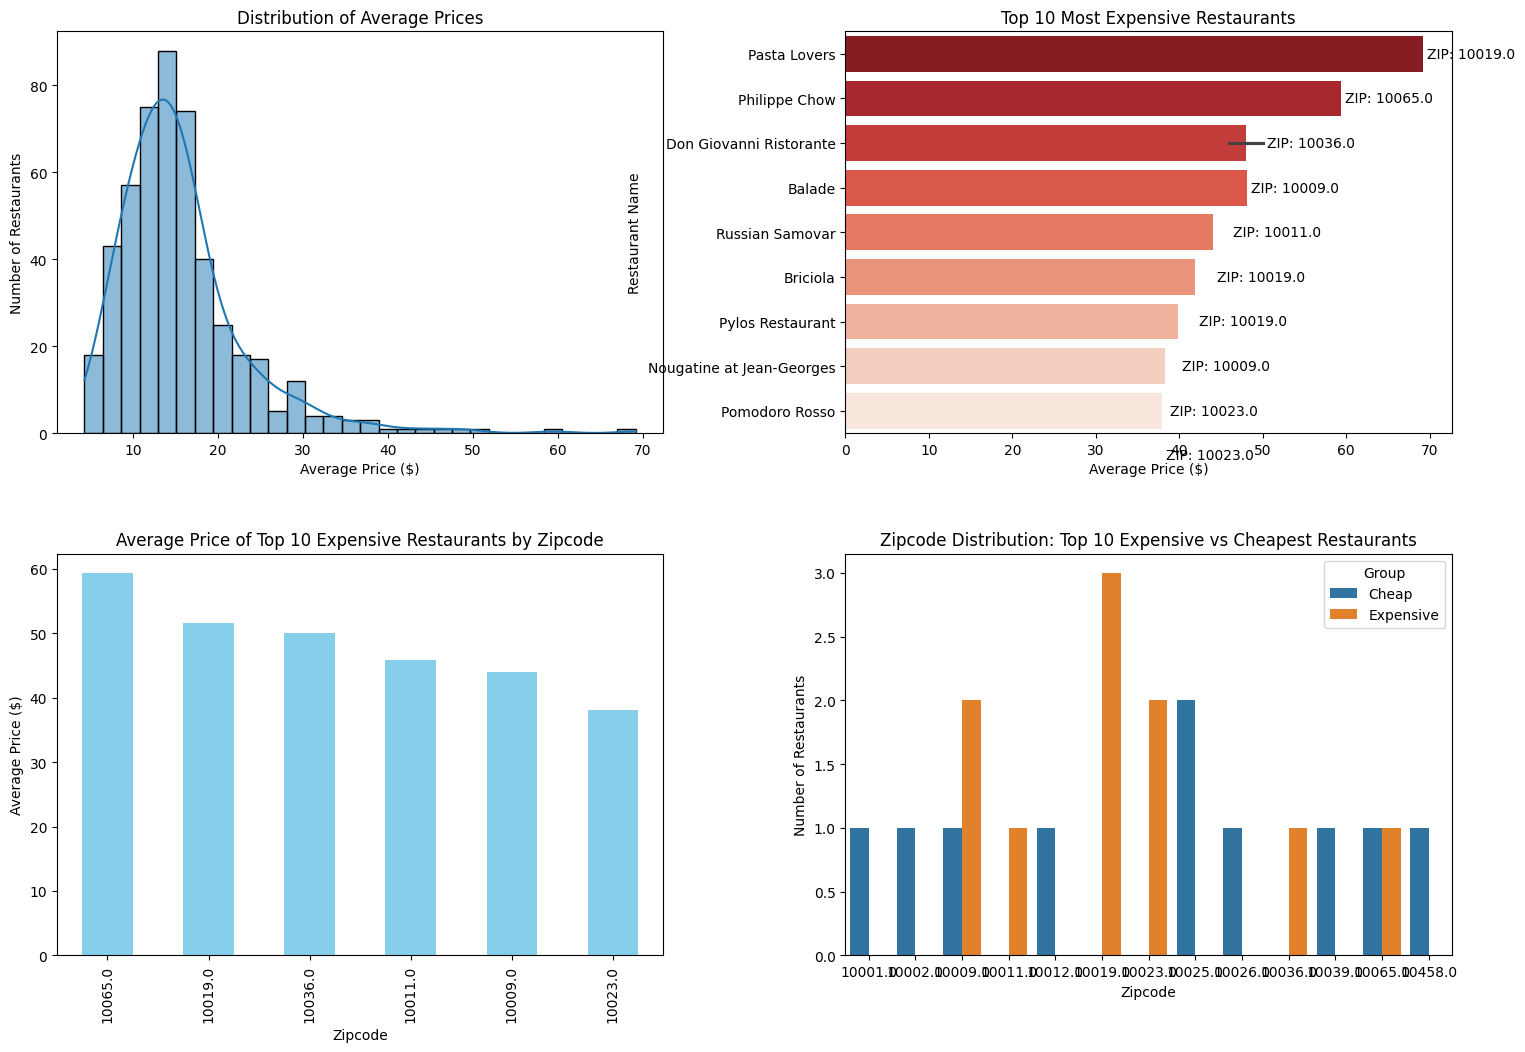

In [47]:
top_n = 10

# Prepare data
top_expensive = df.sort_values(by='Average Price', ascending=False).head(top_n)
top_cheap = df.sort_values(by='Average Price', ascending=True).head(top_n)

zipcode_group = top_expensive.groupby('Zipcode')['Average Price'].mean().sort_values(ascending=False)

combined = pd.concat([
    top_expensive.assign(Group='Expensive'),
    top_cheap.assign(Group='Cheap')
])

# Create subplots
fig, axes = plt.subplots(2, 2, figsize=(18, 12))
plt.subplots_adjust(hspace=0.3, wspace=0.3)

# 1. Histogram of Average Price
sns.histplot(df['Average Price'], bins=30, kde=True, ax=axes[0,0])
axes[0,0].set_title("Distribution of Average Prices")
axes[0,0].set_xlabel("Average Price ($)")
axes[0,0].set_ylabel("Number of Restaurants")

# 2. Top 10 Most Expensive Restaurants Barplot with ZIP code annotation
sns.barplot(data=top_expensive, x='Average Price', y='Name', palette='Reds_r', ax=axes[0,1])
axes[0,1].set_title(f"Top {top_n} Most Expensive Restaurants")
axes[0,1].set_xlabel("Average Price ($)")
axes[0,1].set_ylabel("Restaurant Name")

for i, (price, zipcode) in enumerate(zip(top_expensive['Average Price'], top_expensive['Zipcode'])):
    axes[0,1].text(price + 0.5, i, f'ZIP: {zipcode}', va='center')

# 3. Average Price by Zipcode (Top 10 Expensive)
zipcode_group.plot(kind='bar', ax=axes[1,0], color='skyblue')
axes[1,0].set_title(f"Average Price of Top {top_n} Expensive Restaurants by Zipcode")
axes[1,0].set_xlabel("Zipcode")
axes[1,0].set_ylabel("Average Price ($)")

# 4. Zipcode Distribution: Top 10 Expensive vs Cheapest
sns.countplot(data=combined, x='Zipcode', hue='Group', ax=axes[1,1])
axes[1,1].set_title(f"Zipcode Distribution: Top {top_n} Expensive vs Cheapest Restaurants")
axes[1,1].set_xlabel("Zipcode")
axes[1,1].set_ylabel("Number of Restaurants")
axes[1,1].legend(title='Group')

plt.show()

Price Statistics

In [48]:
print('Price Statistics')
print(f"Mean: ${df['Average Price'].mean():.2f}")
print(f"Median: ${df['Average Price'].median():.2f}")
print(f"Standard Deviation: ${df['Average Price'].std():.2f}")
print(f"Minimum: ${df['Average Price'].min():.2f}")
print(f"Maximum: ${df['Average Price'].max():.2f}")

Price Statistics
Mean: $15.58
Median: $14.12
Standard Deviation: $7.61
Minimum: $4.27
Maximum: $69.20


Correlation Matrix

In [42]:
df_corr = df_clean.copy()

# Frequency encode Cuisine and Name
df_corr['Cuisine_freq'] = df_corr['Cuisine'].map(df_corr['Cuisine'].value_counts())
df_corr['Name_freq'] = df_corr['Name'].map(df_corr['Name'].value_counts())

# Zipcode is numeric already
# Now calculate correlation matrix for numeric columns + encoded ones
cols_to_corr = ['Average Price', 'Zipcode', 'Cuisine_freq', 'Name_freq']

corr_matrix = df_corr[cols_to_corr].corr()

print(corr_matrix['Average Price'].sort_values(ascending=False))


Average Price    1.000000
Cuisine_freq     0.070561
Name_freq        0.003291
Zipcode         -0.037113
Name: Average Price, dtype: float64


Scatter Plot of most correlated features

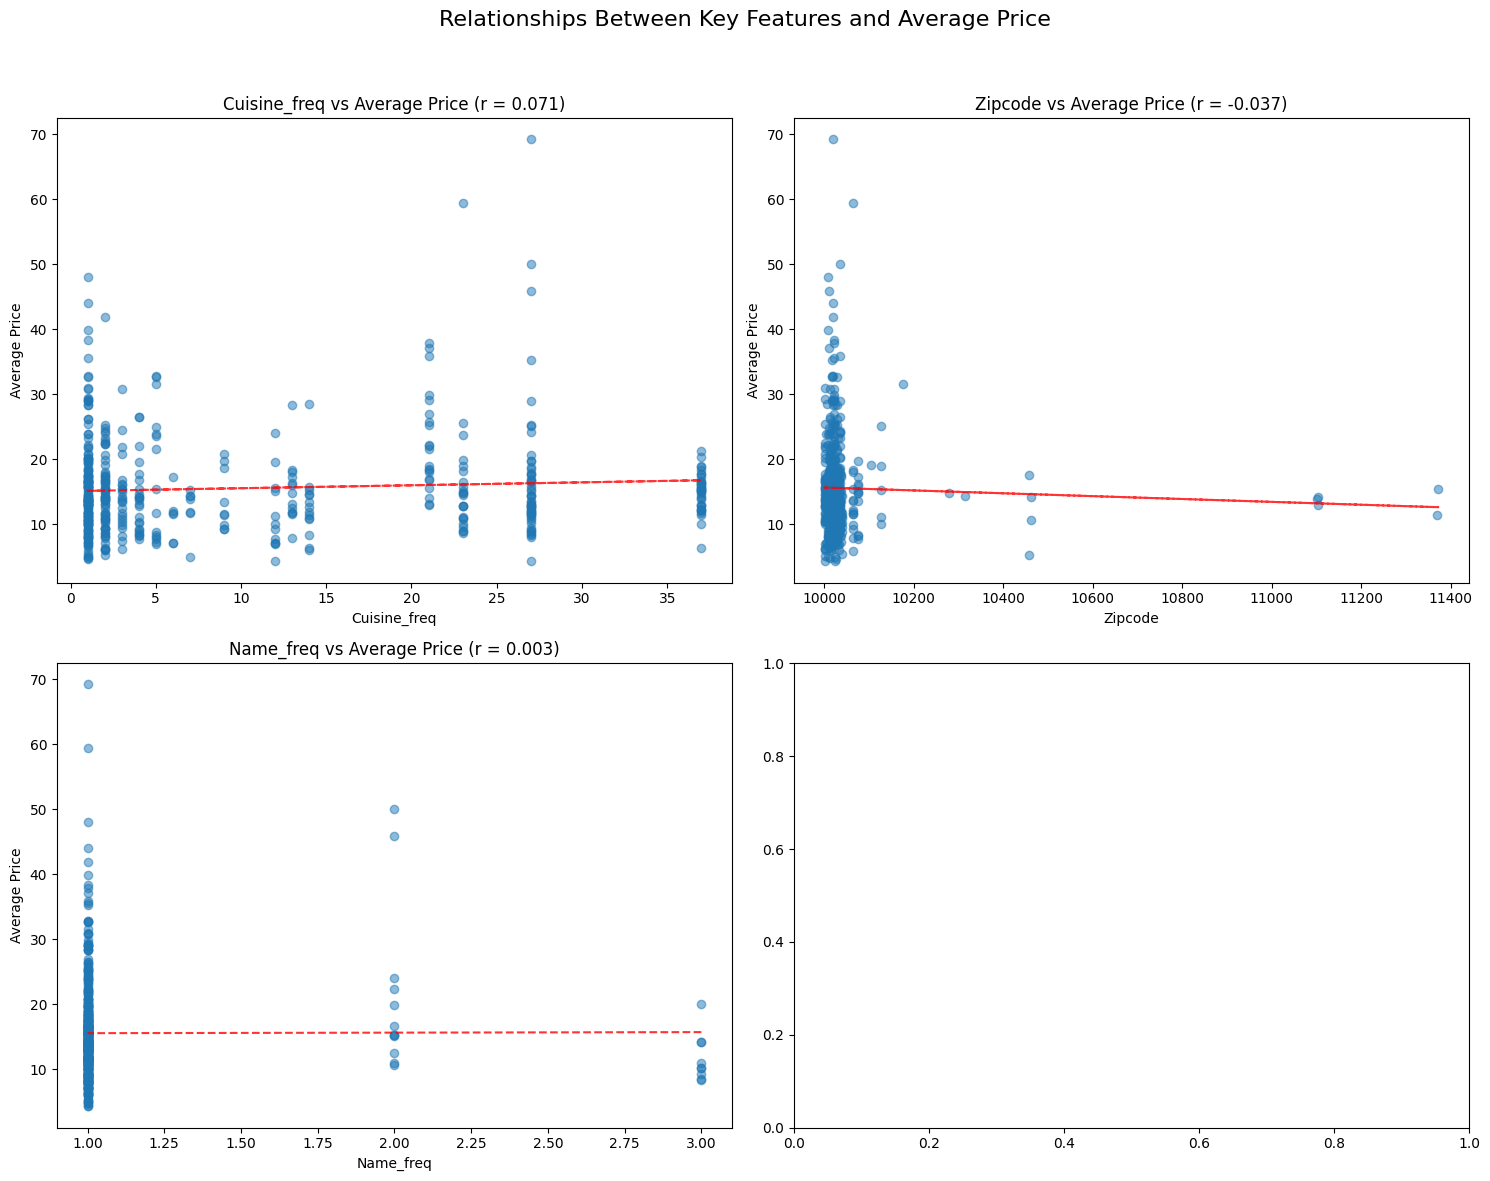

In [137]:
import numpy as np
import matplotlib.pyplot as plt

# Assume corr_matrix is correlation matrix including ['Average Price', 'Cuisine_freq', 'Name_freq', 'Zipcode']
price_correlations = corr_matrix['Average Price'].abs().sort_values(ascending=False).drop('Average Price')

top_features = price_correlations.head(4).index.tolist()

fig, axes = plt.subplots(2, 2, figsize=(15, 12))
fig.suptitle('Relationships Between Key Features and Average Price', fontsize=16)

for i, feature in enumerate(top_features):
    row = i // 2
    col = i % 2

    x = df_corr[feature]
    y = df_corr['Average Price']

    axes[row, col].scatter(x, y, alpha=0.5)
    axes[row, col].set_xlabel(feature)
    axes[row, col].set_ylabel('Average Price')
    corr_val = corr_matrix.loc[feature, 'Average Price']
    axes[row, col].set_title(f'{feature} vs Average Price (r = {corr_val:.3f})')

    # Add trend line
    z = np.polyfit(x, y, 1)
    p = np.poly1d(z)
    axes[row, col].plot(x, p(x), 'r--', alpha=0.8)

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


Data Processing

- Feature Engineering and Categorical Encoding

In [49]:
# Create a copy for preprocessing
df_processed = df.copy()
df_clean = df.dropna().reset_index(drop=True)

# Comparing raw scraped and processed data
print(f"Rows before cleaning: {502}")
print(f"Rows after cleaning: {489}")

print(f"Dropped rows: {502 - 489}")
print(f"Percentage dropped: {(502 - 489) / 502 * 100:.2f}%")
df_processed['Average Price']

Rows before cleaning: 502
Rows after cleaning: 489
Dropped rows: 13
Percentage dropped: 2.59%


,Average Price
0,NaN
1,14.125000
2,14.125000
3,15.744186
4,11.023438
...,...
497,19.502488
498,14.197761
499,8.233929
500,13.607353


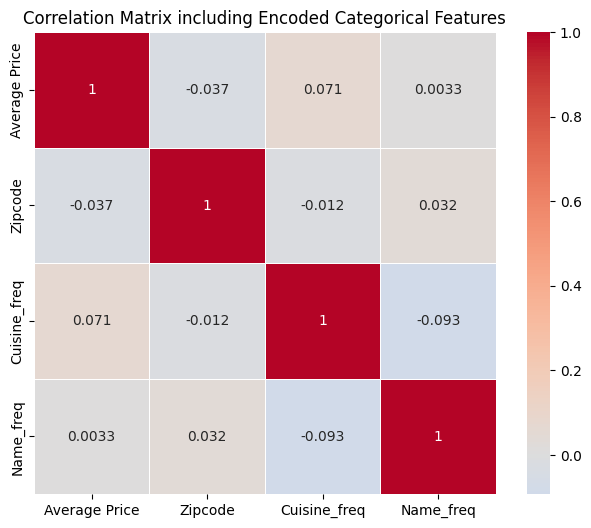

In [43]:
df_corr = df_clean.copy()
df_corr['Cuisine_freq'] = df_corr['Cuisine'].map(df_corr['Cuisine'].value_counts())
df_corr['Name_freq'] = df_corr['Name'].map(df_corr['Name'].value_counts())

cols_to_corr = ['Average Price', 'Zipcode', 'Cuisine_freq', 'Name_freq']

corr_matrix = df_corr[cols_to_corr].corr()

plt.figure(figsize=(8,6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0, square=True, linewidths=0.5)
plt.title('Correlation Matrix including Encoded Categorical Features')
plt.show()

In [51]:
# Define bins for Average Price (adjust values as makes sense for your data)
price_bins = [0, 10, 20, 40, float('inf')]
price_labels = ['Low', 'Medium', 'High', 'Very High']

df_clean['PriceLevel'] = pd.cut(df_clean['Average Price'],
                               bins=price_bins,
                               labels=price_labels,
                               include_lowest=True)


In [52]:
df_clean

,Name,URL,Cuisine,Address,Average Price,Zipcode,PriceLevel
0,Malecon,/ny/new-york/146680-malecon/menu/,Dominican,"5592 Broadway, New York, NY, 10463, 119 7th Av...",14.125000,10025.0,Medium
1,Malecon,/ny/new-york/146680-malecon/menu/,Dominican,"5592 Broadway, New York, NY, 10463",14.125000,10463.0,Medium
2,Cafeteria,/ny/new-york/3112-cafeteria/menu/,Diner,"119 7th Ave, New York, NY, 10011",15.744186,10011.0,Medium
3,Jimbo's Hamburger Palace,/ny/new-york/47963-jimbos-hamburger-palace/menu/,"American, Burgers","117 Dyckman St, New York, NY, 10040",11.023438,10040.0,Medium
4,Del Frisco's Double Eagle Steakhouse,/ny/new-york/247022-del-friscos-double-eagle-s...,Steak,"1221 6th Ave, New York, NY, 10020",32.734105,10020.0,High
...,...,...,...,...,...,...,...
484,Crompton Ale House,/ny/new-york/484969-crompton-ale-house/menu/,"American (New), Irish","159 W 26th St, New York, NY, 10001",19.502488,10001.0,Medium
485,Mercer Kitchen,/ny/new-york/267076-mercer-kitchen/menu/,"American (New), Pizza","99 Prince St, New York, NY, 10012",14.197761,10012.0,Medium
486,Famous Famiglia Pizzeria,/ny/new-york/111175-famous-famiglia-pizzeria/m...,"Italian, Pasta, Pizza","686 8th Ave, New York, NY, 10036",8.233929,10036.0,Low
487,The Triple Crown,/ny/new-york/7722-the-triple-crown/menu/,"American, Bar Food","330 7th Ave, New York, NY, 10001",13.607353,10001.0,Medium


In [53]:
# new categorical distribution
print('New categorical features created:')
print('\nPrice Level distribution')
print(df_clean['PriceLevel'].value_counts())

New categorical features created:

Price Level distribution
PriceLevel
Medium       311
Low           93
High          78
Very High      7
Name: count, dtype: int64


In [55]:
# One-Hot Encoding for categorial variables
print('Before one-hot encoding')
print(f'Shape: {df_clean.shape}')
print(f'Columns: {list(df_clean.columns)}')


Before one-hot encoding
Shape: (489, 7)
Columns: ['Name', 'URL', 'Cuisine', 'Address', 'Average Price', 'Zipcode', 'PriceLevel']


In [87]:
# Calculate and add frequency columns
df_clean['Zipcode_freq'] = df_clean['Zipcode'].map(df_clean['Zipcode'].value_counts(normalize=True))
df_clean['Cuisine_freq'] = df_clean['Cuisine'].map(df_clean['Cuisine'].value_counts(normalize=True))

# One-hot encode PriceLevel as before
df_encoded = pd.get_dummies(df_clean, columns=['PriceLevel'], prefix=['Price'], drop_first=True)


In [92]:
df_encoded

,Name,URL,Cuisine,Address,Average Price,Zipcode,Zipcode_freq,Cuisine_freq,Price_Medium,Price_High,Price_Very High
0,Malecon,/ny/new-york/146680-malecon/menu/,Dominican,"5592 Broadway, New York, NY, 10463, 119 7th Av...",14.125000,10025.0,0.032720,0.008180,True,False,False
1,Malecon,/ny/new-york/146680-malecon/menu/,Dominican,"5592 Broadway, New York, NY, 10463",14.125000,10463.0,0.004090,0.008180,True,False,False
2,Cafeteria,/ny/new-york/3112-cafeteria/menu/,Diner,"119 7th Ave, New York, NY, 10011",15.744186,10011.0,0.040900,0.075665,True,False,False
3,Jimbo's Hamburger Palace,/ny/new-york/47963-jimbos-hamburger-palace/menu/,"American, Burgers","117 Dyckman St, New York, NY, 10040",11.023438,10040.0,0.010225,0.004090,True,False,False
4,Del Frisco's Double Eagle Steakhouse,/ny/new-york/247022-del-friscos-double-eagle-s...,Steak,"1221 6th Ave, New York, NY, 10020",32.734105,10020.0,0.004090,0.010225,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...
484,Crompton Ale House,/ny/new-york/484969-crompton-ale-house/menu/,"American (New), Irish","159 W 26th St, New York, NY, 10001",19.502488,10001.0,0.024540,0.002045,True,False,False
485,Mercer Kitchen,/ny/new-york/267076-mercer-kitchen/menu/,"American (New), Pizza","99 Prince St, New York, NY, 10012",14.197761,10012.0,0.051125,0.002045,True,False,False
486,Famous Famiglia Pizzeria,/ny/new-york/111175-famous-famiglia-pizzeria/m...,"Italian, Pasta, Pizza","686 8th Ave, New York, NY, 10036",8.233929,10036.0,0.057260,0.002045,False,False,False
487,The Triple Crown,/ny/new-york/7722-the-triple-crown/menu/,"American, Bar Food","330 7th Ave, New York, NY, 10001",13.607353,10001.0,0.024540,0.006135,True,False,False


In [94]:
print('\n After one-hot encoding:')
print(f'Shape: {df_encoded.shape}')
print(df_encoded.dtypes)



 After one-hot encoding:
Shape: (489, 11)
Name                object
URL                 object
Cuisine             object
Address             object
Average Price      float64
Zipcode            float64
Zipcode_freq       float64
Cuisine_freq       float64
Price_Medium          bool
Price_High            bool
Price_Very High       bool
dtype: object


Train-Test Split

In [95]:
df_encoded

,Name,URL,Cuisine,Address,Average Price,Zipcode,Zipcode_freq,Cuisine_freq,Price_Medium,Price_High,Price_Very High
0,Malecon,/ny/new-york/146680-malecon/menu/,Dominican,"5592 Broadway, New York, NY, 10463, 119 7th Av...",14.125000,10025.0,0.032720,0.008180,True,False,False
1,Malecon,/ny/new-york/146680-malecon/menu/,Dominican,"5592 Broadway, New York, NY, 10463",14.125000,10463.0,0.004090,0.008180,True,False,False
2,Cafeteria,/ny/new-york/3112-cafeteria/menu/,Diner,"119 7th Ave, New York, NY, 10011",15.744186,10011.0,0.040900,0.075665,True,False,False
3,Jimbo's Hamburger Palace,/ny/new-york/47963-jimbos-hamburger-palace/menu/,"American, Burgers","117 Dyckman St, New York, NY, 10040",11.023438,10040.0,0.010225,0.004090,True,False,False
4,Del Frisco's Double Eagle Steakhouse,/ny/new-york/247022-del-friscos-double-eagle-s...,Steak,"1221 6th Ave, New York, NY, 10020",32.734105,10020.0,0.004090,0.010225,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...
484,Crompton Ale House,/ny/new-york/484969-crompton-ale-house/menu/,"American (New), Irish","159 W 26th St, New York, NY, 10001",19.502488,10001.0,0.024540,0.002045,True,False,False
485,Mercer Kitchen,/ny/new-york/267076-mercer-kitchen/menu/,"American (New), Pizza","99 Prince St, New York, NY, 10012",14.197761,10012.0,0.051125,0.002045,True,False,False
486,Famous Famiglia Pizzeria,/ny/new-york/111175-famous-famiglia-pizzeria/m...,"Italian, Pasta, Pizza","686 8th Ave, New York, NY, 10036",8.233929,10036.0,0.057260,0.002045,False,False,False
487,The Triple Crown,/ny/new-york/7722-the-triple-crown/menu/,"American, Bar Food","330 7th Ave, New York, NY, 10001",13.607353,10001.0,0.024540,0.006135,True,False,False


In [102]:
df_encoded.columns

Index(['Name', 'URL', 'Cuisine', 'Address', 'Average Price', 'Zipcode',
       'Zipcode_freq', 'Cuisine_freq', 'Price_Medium', 'Price_High',
       'Price_Very High'],
      dtype='object')

In [120]:
# Separate Features from the Target
X = df_encoded[['Zipcode',
       'Zipcode_freq', 'Cuisine_freq', 'Price_Medium', 'Price_High',
       'Price_Very High']]

In [121]:
X

,Zipcode,Zipcode_freq,Cuisine_freq,Price_Medium,Price_High,Price_Very High
0,10025.0,0.032720,0.008180,True,False,False
1,10463.0,0.004090,0.008180,True,False,False
2,10011.0,0.040900,0.075665,True,False,False
3,10040.0,0.010225,0.004090,True,False,False
4,10020.0,0.004090,0.010225,False,True,False
...,...,...,...,...,...,...
484,10001.0,0.024540,0.002045,True,False,False
485,10012.0,0.051125,0.002045,True,False,False
486,10036.0,0.057260,0.002045,False,False,False
487,10001.0,0.024540,0.006135,True,False,False


In [122]:
y = df_encoded['Average Price']

In [123]:
y

,Average Price
0,14.125000
1,14.125000
2,15.744186
3,11.023438
4,32.734105
...,...
484,19.502488
485,14.197761
486,8.233929
487,13.607353


In [124]:
# features shape
print(f'Features shape: {X.shape}')
print(f'Target shape: {y.shape}')

Features shape: (489, 6)
Target shape: (489,)


In [125]:
# get feature names
print(f'Feature names: {list(X.columns)}')

Feature names: ['Zipcode', 'Zipcode_freq', 'Cuisine_freq', 'Price_Medium', 'Price_High', 'Price_Very High']


In [126]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

In [127]:
# take a look at the shapes of the training and testing sets
print(f'Training set shape {X_train.shape}')
print(f'Test set shape {X_test.shape}')
print(f'Training target set shape {y_train.shape}')
print(f'Testing target set shape {y_test.shape}')

Training set shape (391, 6)
Test set shape (98, 6)
Training target set shape (391,)
Testing target set shape (98,)


In [146]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

In [147]:
# Feature scaling using StandardScaler
print('Before scaling - Training set statistics')
print(X_train.describe())

Before scaling - Training set statistics
            Zipcode  Zipcode_freq  Cuisine_freq
count    391.000000    391.000000    391.000000
mean   10044.260870      0.034310      0.021846
std      142.620254      0.017766      0.024830
min    10001.000000      0.002045      0.002045
25%    10012.000000      0.022495      0.002045
50%    10021.000000      0.030675      0.006135
75%    10032.000000      0.051125      0.044990
max    11372.000000      0.069530      0.075665


In [148]:
# Initialize the scaler
scaler = StandardScaler()

# Fit the scaler on the training data and transform both training and testing data
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)
type(X_train_scaled)

numpy.ndarray

In [151]:
# Convert back to DataFrame for easier handling
X_train_scaled = pd.DataFrame(X_train_scaled, columns = X_train.columns, index = X_train.index)
X_test_scaled = pd.DataFrame(X_test_scaled, columns = X_test.columns, index = X_test.index)


In [152]:
print('After Scaler - Training set statistics')
print(X_train_scaled.describe())


After Scaler - Training set statistics
            Zipcode  Zipcode_freq  Cuisine_freq  Price_Medium    Price_High  \
count  3.910000e+02  3.910000e+02  3.910000e+02  3.910000e+02  3.910000e+02   
mean  -3.884361e-15  8.177602e-17 -7.950446e-17  3.634490e-17 -1.362934e-17   
std    1.001281e+00  1.001281e+00  1.001281e+00  1.001281e+00  1.001281e+00   
min   -3.037177e-01 -1.818401e+00 -7.984925e-01 -1.346458e+00 -4.465272e-01   
25%   -2.264910e-01 -6.658725e-01 -7.984925e-01 -1.346458e+00 -4.465272e-01   
50%   -1.633055e-01 -2.048612e-01 -6.335636e-01  7.426892e-01 -4.465272e-01   
75%   -8.607879e-02  9.476672e-01  9.332619e-01  7.426892e-01 -4.465272e-01   
max    9.321539e+00  1.984943e+00  2.170229e+00  7.426892e-01  2.239505e+00   

       Price_Very High  
count     3.910000e+02  
mean      2.271556e-18  
std       1.001281e+00  
min      -1.138129e-01  
25%      -1.138129e-01  
50%      -1.138129e-01  
75%      -1.138129e-01  
max       8.786353e+00  


Multiple Linear Regression

In [153]:
regression_model = LinearRegression()

# training the model
regression_model.fit(X_train_scaled, y_train)

# Make predictions
y_pred_train = regression_model.predict(X_train_scaled)

y_pred_test = regression_model.predict(X_test_scaled)



In [154]:
# calculate performance metrics for both training and testing sets
def calculate_metrics(y_true, y_pred, dataset):
  mse = mean_squared_error(y_true, y_pred)
  rmse = np.sqrt(mse)
  mae = mean_absolute_error(y_true, y_pred)
  r2 = r2_score(y_true, y_pred)

  print(f'Performance Metrics: {dataset}')
  print(f"Mean Squared Error (MSE): {mse:.4f}")
  print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
  print(f"Mean Absolute Error (MAE): {mae:.4f}")
  print(f"R-squared (R²) Score: {r2:.4f}")

In [155]:
# Training test performance
calculate_metrics(y_train, y_pred_train, 'Training')

Performance Metrics: Training
Mean Squared Error (MSE): 10.1861
Root Mean Squared Error (RMSE): 3.1916
Mean Absolute Error (MAE): 2.4207
R-squared (R²) Score: 0.8282


In [156]:
# Testing Data Performance
calculate_metrics(y_test, y_pred_test, 'Testing')

Performance Metrics: Testing
Mean Squared Error (MSE): 7.9740
Root Mean Squared Error (RMSE): 2.8238
Mean Absolute Error (MAE): 2.1929
R-squared (R²) Score: 0.8488
